In [1]:
import rtde_control
import rtde_receive
import numpy as np
import sys
import yaml
from matplotlib import pyplot as plt
import pyrealsense2 as rs
import cv2
import torch

import time
from collections import deque


from force_control import z_force_control

sys.path.append("../../")

from scripts.SurfaceContact.move import move_default_pose

from scripts.SurfaceContact.control import SurfaceContactControl
from scripts.USImageCV.models.unet import UNet
from scripts.USImageCV.utils.bunny import bunny_mask_predict, load_bunny_model,max_connected_area
%load_ext autoreload
%autoreload 2

# Connect to robot

In [2]:
# from recording_upload_server import CaptureServer

rtde_c = rtde_control.RTDEControlInterface("192.168.1.2")
rtde_r = rtde_receive.RTDEReceiveInterface("192.168.1.2")



# Connect to ultrasound image stream

In [3]:
ultrasoud_vid = cv2.VideoCapture('/dev/video8')

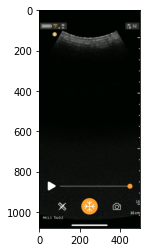

In [4]:

ret, frame = ultrasoud_vid.read()		
plt.imshow(frame)

# Load pre-trained bunny segmentation model

In [5]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = load_bunny_model('../../scripts/USImageCV/model_weights/vessel_model.pth',device)

# Connect to RGB-D Camera

In [12]:
pipeline = rs.pipeline()
pipeline.start()


# Initialize surface finding controller

In [14]:
with open('../../config/pose_in_TCP_frame.yaml','r') as f:
    poses = yaml.safe_load(f)

    camera_2_tcp = poses['camera']
    probe_2_tcp = poses['probe']
    
body_color_rgb = (227,124,100)
body_hsv_rad = (5,50,100)
# rtde_c = rtde_r = []
sc = SurfaceContactControl(pipeline,rtde_c,rtde_r,
                           camera_2_tcp,probe_2_tcp,
                           body_color_rgb,body_hsv_rad)

In [8]:
move_default_pose(rtde_c)

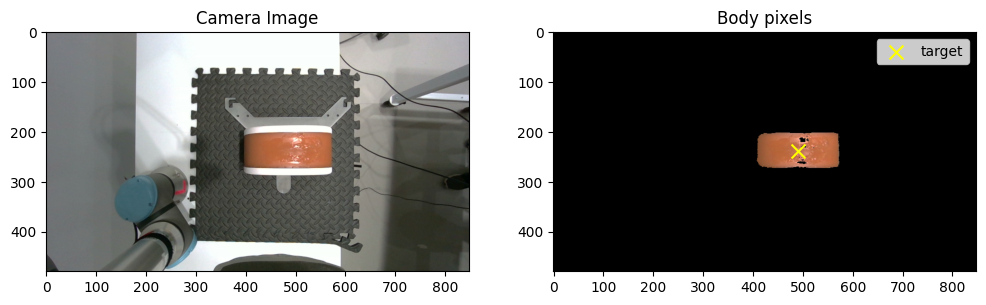

In [15]:
sc.fetchCameraStreamData()
fig = plt.figure(dpi=100,figsize = (12,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
sc.showScene([ax1,ax2])


# Utility functions

In [115]:

def find_surface(sc):
    for _ in range(40):
        dist = sc.mainloop()
        dist_threshold = 0.005
        if dist<dist_threshold:
            break
    print("Arrived at above target location. Start descending.")

    sc.loc_normal_control(hover_height=0.20)
    # s = input("Find surface:?")

    if sc.getContact():
        print("Contact made.")

def y_direction_search():
    # y direction search has to be very careful, with low speed vel=0.001
    tcp_pose = rtde_r.getActualTCPPose()

    start_pose = rtde_c.poseTrans(tcp_pose,[0,-0.02,0,0,0,0])

    target_pose = rtde_c.poseTrans(tcp_pose,[0,+0.02,0,0,0,0])

    return bunny_view_optim(rtde_c,rtde_r,start_pose,target_pose,
                        ultrasoud_vid,
                        model,device,
                        search_vel = 0.001,
                        search_acc = 0.1)

def x_direction_search():
    # x direction search can be more crude, with intermediate speed vel=0.01
    tcp_pose = rtde_r.getActualTCPPose()

    start_pose = rtde_c.poseTrans(tcp_pose,[-0.05,0,0,0,0,0])

    target_pose = rtde_c.poseTrans(tcp_pose,[+0.05,0,0,0,0,0])

    return bunny_view_optim(rtde_c,rtde_r,start_pose,target_pose,
                        ultrasoud_vid,
                        model,device,
                        search_vel = 0.01,
                        search_acc = 0.1)

def bunny_view_optim(rtde_c,rtde_r,start_pose,target_pose,
                     ultrasoud_vid,
                     model,device,
                     search_vel=0.001,
                     search_acc=0.1):
    # Optimize the bunny view by traversing the robot from a start pose to a goal pose.

    # Move the TCP to the starting pose.
    rtde_c.moveL(start_pose,0.01,0.1) 
    
    # After reaching the starting pose, fire off the TCP to move towards the target_pose.
    # Setting asynchoronous=True allows the code to fly forward while the robot execute the motion independently.
    rtde_c.moveL(target_pose,search_vel,search_acc,asynchronous=True) 
    
    # In the asynchorous mode of moveL, we have to actively monitor the robot speed to determine whether the robot has stopped.
    speeds = []
    start_time = time.time()

    time.sleep(0.01) # This will allow the robot to start moving a little
    area_diff = deque(maxlen=3)

    max_area = 0
    optim_pose = []
    frames = []
    for i in range(1000):
        linear_tcp_speed = np.linalg.norm(rtde_r.getActualTCPSpeed()[:3])
        speeds.append(linear_tcp_speed)
        
        ret, frame = ultrasoud_vid.read()	
        frames.append(frame)
        ###### Must record the curr_pose right after the image read and before the neural network inference.
        curr_pose = rtde_r.getActualTCPPose()	
        ######


        mask = bunny_mask_predict(model,frame,device)
        area = max_connected_area(mask)
        # print("area",area,"Time elapsed:",time.time()-start_time)
        area_diff.append(area)
        
        if area>max_area:
            max_area = area
            optim_pose = curr_pose
        
        if len(area_diff)>=3 and\
             np.min(area_diff)>4000 and \
                area_diff[-1]-area_diff[-2]<0 and area_diff[-2]-area_diff[-3]<0:
            # If the area starts to consistently decline, stop the robot. 
            # print(list(area_diff))
            rtde_c.stopL() 
            # We can call stopL() to manually stop the robot during execution.
            # This is very useful pairing with the async move of moveL.

            # And move the robot to the optimal pose
            rtde_c.moveL(optim_pose,0.01,0.1)

            return max_area,frames
        
        if linear_tcp_speed<1e-4:
            return max_area,frames
def find_bunny():
    max_a = 0
    while True:
        y_direction_search()
        
        a,_ = x_direction_search()
        print('Max area',a)
        if a>=max_a:
            max_a = a
        if max_a>=7000:
            break


In [ ]:
def record_registration():
    start_pose = rtde_r.getActualTCPPose()
    frames = []
    poses = []
    # Move and record in one direction
    target_pose = rtde_c.poseTrans(start_pose,[0,-0.02,0,0,0,0])
    frames,poses = record_registration_frames(rtde_c,rtde_r,start_pose,target_pose,
                        ultrasoud_vid,
                        model,device,
                        n_waypoints = 50)
    # Move and record in the opposite direction
    target_pose = rtde_c.poseTrans(start_pose,[0,0.02,0,0,0,0])
    f,p = record_registration_frames(rtde_c,rtde_r,start_pose,target_pose,
                        ultrasoud_vid,
                        model,device,
                        n_waypoints = 50)
    
    frames+=f
    poses+=p
    return frames,poses
def record_registration_frames(rtde_c,rtde_r,start_pose,target_pose,
                     ultrasoud_vid,
                     model,device,
                    n_waypoints = 50):

    start_loc = start_pose[:3]
    target_loc = target_pose[:3]
    waypoints = np.linspace(start_loc,target_loc,n_waypoints)
    waypoints = [list(w)+start_pose[3:] for w in waypoints]

    rtde_c.moveL(start_pose,0.01,0.1)
    # y direction search has to be very careful, with low speed vel=0.001
    tcp_pose = rtde_r.getActualTCPPose()
    start_pose = tcp_pose

    # In the asynchorous mode of moveL, we have to actively monitor the robot speed to determine whether the robot has stopped.
    speeds = []
    start_time = time.time()

    time.sleep(0.01) # This will allow the robot to start moving a little
    n_hist = 5
    areas = deque(maxlen=n_hist)

    poses=[]
    frames = []
    for w in waypoints:
        
        ret, frame = ultrasoud_vid.read()
        frames.append(frame)
        ###### Must record the curr_pose right after the image read and before the neural network inference.
        curr_pose = rtde_r.getActualTCPPose()	
        poses.append(curr_pose)
        ######
        mask = bunny_mask_predict(model,frame,device)
        area = max_connected_area(mask)
        print("area",area,"Time elapsed:",time.time()-start_time)
        areas.append(area)
        if len(areas)>=n_hist and np.max(areas)<=2000:
            # If the area starts to consistently be small, stop the robot.
            # And move the robot to the start pose
            break
        rtde_c.moveL(w,0.01,0.1)
    rtde_c.moveL(start_pose,0.01,0.1)
    return frames,poses

In [118]:
move_default_pose(rtde_c)


In [117]:
# Start the control pipeline
move_default_pose(rtde_c)
w0 = rtde_r.getActualTCPForce()# Record force zero

find_surface(sc)

target_force = 13
force_err_tolerance = 0.2
z_force_control(target_force,rtde_r,rtde_c,w0)

find_bunny()
frames = record_registration()

Arrived at above target location. Start descending.
Contact made.


Current force is:13.107668115552912:  Time elapsed=00:07


Target force reached.
Max area 6209
Max area 8224
area 8091 Time elapsed: 0.6211602687835693
area 8059 Time elapsed: 1.2601838111877441
area 8091 Time elapsed: 1.973646640777588
area 7979 Time elapsed: 2.693678617477417
area 8134 Time elapsed: 3.4289638996124268
area 8127 Time elapsed: 4.1464316844940186
area 5961 Time elapsed: 4.859456539154053
area 5933 Time elapsed: 5.593041896820068
area 5768 Time elapsed: 6.297450304031372
area 5768 Time elapsed: 6.997691869735718
area 5444 Time elapsed: 7.7248570919036865
area 5469 Time elapsed: 8.413802862167358
area 5529 Time elapsed: 9.129099607467651
area 5616 Time elapsed: 9.859219312667847
area 5476 Time elapsed: 10.59265923500061
area 5512 Time elapsed: 11.323827505111694
area 5556 Time elapsed: 12.14136028289795
area 5592 Time elapsed: 12.842721223831177
area 5356 Time elapsed: 13.60625672340393
area 5100 Time elapsed: 14.308018922805786
area 4868 Time elapsed: 15.055755615234375
area 4661 Time elapsed: 15.760534048080444
area 4254 Time e

# Clean up

In [ ]:
ultrasoud_vid.release()
pipeline.stop()

# Useful Scripts

In [ ]:
# Script for saving default pose
with open('../config/default_pose.yaml','w') as f:
    yaml.safe_dump({'default_pose':rtde_r.getActualTCPPose()},f)